---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Spatial network segmentation
### Demonstrating network segmentation

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is an advanced walk-through for:**

1. Demonstrating network segmentation
2. Understanding observation counts per network arc
3. Visualizing network representations with emprical and synthetic data

In [1]:
%load_ext watermark
%watermark

2020-10-22T17:25:40-04:00

CPython 3.8.5
IPython 7.18.1

compiler   : Clang 10.0.1 
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [2]:
import libpysal
import matplotlib
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy
import spaghetti

%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
matplotlib_scalebar 0.6.2
numpy               1.19.1
spaghetti           1.5.1
matplotlib          3.3.2
libpysal            4.3.0



In [3]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

----------------

### Instantiating a `spaghetti.Network` object and a point pattern
#### Instantiate the network from a `.shp` file

In [4]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))

#### Associate the network with a point pattern

In [5]:
pp_name = "crimes"
pp_shp = libpysal.examples.get_path("%s.shp" % pp_name)
ntw.snapobservations(pp_shp, pp_name, attribute=True)
ntw.pointpatterns

{'crimes': <spaghetti.network.PointPattern at 0x7ff939ebfa60>}

-----------------------------

### 1. Network segmentation

#### Split network arcs into segments of 200 distance units ([US feet is this case](https://github.com/pysal/libpysal/blob/master/libpysal/examples/geodanet/streets.prj))

In [6]:
n200 = ntw.split_arcs(200.0)
n200

#### The returned object inherits many of the attributes from the original network

In [7]:
print(dir(n200))

['GlobalAutoK', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_evaluate_napts', '_extractnetwork', '_newpoint_coords', '_round_sig', '_snap_to_link', '_yield_napts', '_yieldneighbor', 'adjacencylist', 'allneighbordistances', 'arc_lengths', 'arcs', 'compute_distance_to_vertices', 'compute_snap_dist', 'contiguityweights', 'count_per_link', 'distancebandweights', 'enum_links_vertex', 'extractgraph', 'full_distance_matrix', 'identify_components', 'in_data', 'loadnetwork', 'nearestneighbordistances', 'network_component2arc', 'network_component_is_ring', 'network_component_labels', 'network_component_lengths', 'network_component_vertex_count', 'network_component_vertices', 'network_fully_connected'

In [8]:
n200.pointpatterns

{'crimes': <spaghetti.network.PointPattern at 0x7ff918c3c880>}

#### Extract the elements from both the original network and the split network

In [9]:
# 'full' unsegmented network
vtx_df, arc_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

# network segmented at 200-foot increments
vtx200_df, arc200_df = spaghetti.element_as_gdf(n200, vertices=True, arcs=True)

# crimes point pattern
pp_df = spaghetti.element_as_gdf(ntw, pp_name=pp_name)

#### Plotter function

In [10]:
def plotter():
    """Generate a spatial plot."""
    
    def _patch(_kws, labinfo):
        """Generate a legend patch."""
        label = "%s — %s" % tuple(labinfo)
        _kws.update({"lw":0, "label":label, "alpha":.5})
        return matplotlib.lines.Line2D([], [], **_kws)
    
    def _legend(handles, anchor=(1., .75)):
        """Generate a legend."""
        lkws = {"fancybox":True,"framealpha":0.85, "fontsize":"xx-large"}
        lkws.update({"bbox_to_anchor": anchor, "labelspacing": 2.})
        lkws.update({"borderpad": 1., "handletextpad":1.})
        lkws.update({"title": "Characteristics of a\nsegmented network", "title_fontsize":20})
        matplotlib.pyplot.legend(handles=handles, **lkws)
    
    base = arc_df.plot(color="k", figsize=(9, 9), alpha=.25, zorder=0)
    patches = []
    gdfs, alphas = [vtx_df, vtx200_df, pp_df], [.25, .5, .5]
    colors, zo = ["k", "g", "r"], [1 ,2 ,3]
    markers, markersizes = ["o", "o", "x"], [100, 15, 30]
    labels = [["Original vertices"], ["200-meter vertices"], ["Crimes"]]
    iterinfo = list(zip(gdfs, colors, zo, markers, markersizes, labels, alphas))
    for gdf, c, z, m, ms, lab, a in iterinfo:
        gdf.plot(ax=base, c=c, marker=m, markersize=ms, zorder=z, alpha=a)
        ms = ms/5. if z != 1 else ms/9.
        patch_args = {"marker":m, "markersize":ms,"c":c}, lab+[gdf.shape[0]]
        patches.append(_patch(*patch_args))
    _legend(patches)
    carto_elements(base)

def carto_elements(b):
    """Add/adjust cartographic elements."""
    kw = {"units":"ft", "dimension":"imperial-length", "fixed_value":1000}
    b.add_artist(ScaleBar(1, box_alpha=.75, **kw))
    b.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);

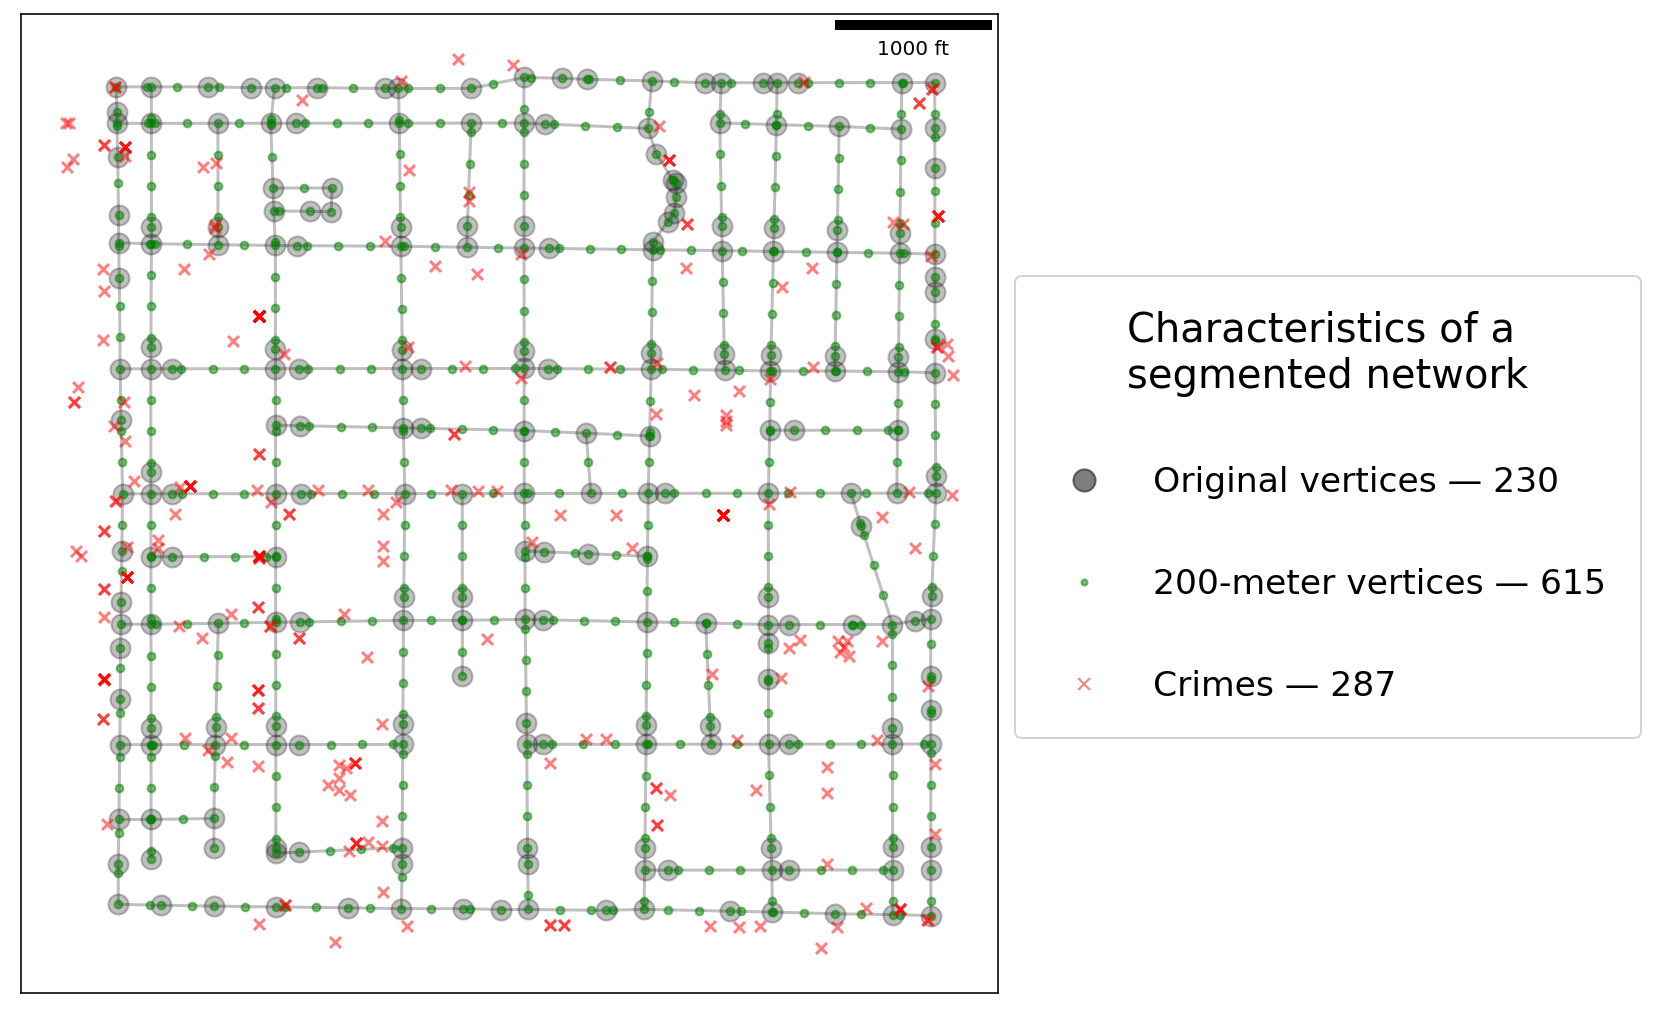

In [11]:
plotter()

**As is shown above, performing (relatively) uniform segmentation results in a more granulated network.**

---------------------

### 2. Counts per link

#### Counts per link may vary considerably depending on the granularity of the network.

In [12]:
def fetch_cpl(net, pp, mean=True):
    """Create a counts per link object and find mean."""
    cpl = net.count_per_link(net.pointpatterns[pp].obs_to_arc, graph=False)
    if mean:
        mean_cpl = sum(list(cpl.values())) / float(len(cpl.keys()))
        return cpl, mean_cpl
    return cpl

In [13]:
ntw_counts, ntw_ctmean = fetch_cpl(ntw, pp_name)
ntw_ctmean

2.682242990654206

In [14]:
n200_counts, n200_ctmean = fetch_cpl(n200, pp_name)
n200_ctmean

2.05

In [15]:
def counts_col(cts, df, join, col, transform="log10"):
    """Create a counts per link dataframe column and transform."""
    df[col] = df[join].map(cts).fillna(0.)
    if transform:
        t = getattr(numpy, "log10")
        df["%s_%s"%(col, transform)] = df[col].apply(lambda x:
            0.0 if x == 0. else (.2 if x == 1. else t(x))
        )
    return df

#### Original network

In [16]:
arc_df = counts_col(ntw_counts, arc_df, "id", "n_crimes")
arc_df.head()

,id,geometry,comp_label,n_crimes,n_crimes_log10
0,"(0, 1)","LINESTRING (728368.048 877125.895, 728368.139 ...",0,0.0,0.000000
1,"(0, 2)","LINESTRING (728368.048 877125.895, 728367.458 ...",0,1.0,0.200000
2,"(1, 110)","LINESTRING (728368.139 877023.272, 728612.255 ...",0,0.0,0.000000
3,"(1, 127)","LINESTRING (728368.139 877023.272, 727708.140 ...",0,3.0,0.477121
4,"(1, 213)","LINESTRING (728368.139 877023.272, 728368.729 ...",0,0.0,0.000000


#### 200-meter segmented network

In [17]:
arc200_df = counts_col(n200_counts, arc200_df, "id", "n_crimes")
arc200_df.head()

,id,geometry,comp_label,n_crimes,n_crimes_log10
0,"(0, 1)","LINESTRING (728368.048 877125.895, 728368.139 ...",0,0.0,0.0
1,"(0, 230)","LINESTRING (728368.048 877125.895, 728367.869 ...",0,0.0,0.0
2,"(1, 233)","LINESTRING (728368.139 877023.272, 728568.139 ...",0,0.0,0.0
3,"(1, 234)","LINESTRING (728368.139 877023.272, 728168.139 ...",0,1.0,0.2
4,"(1, 237)","LINESTRING (728368.139 877023.272, 728368.318 ...",0,0.0,0.0


-------------------

### 3. Visualizing differences for comparison
**Frequently it is acceptable to transform raw counts in order to better visualize the data.**

In [18]:
def truncated_cmap(cm, vmin, vmax, steps):
    """Truncate a matplotlib colormap object"""
    lspace = numpy.linspace(vmin, vmax, steps)
    args = "trunc(%s,%.2f,%.2f)" % (cm.name, vmin, vmax), cm(lspace)
    tcmap = matplotlib.colors.LinearSegmentedColormap.from_list(*args)
    return tcmap
in_cmap = matplotlib.pyplot.get_cmap("inferno")
out_cmap = truncated_cmap(in_cmap, 0.2, 0.8, 100)

In [19]:
def sidexside_plot(df1, df2, col, cmap, supt, subt1, subt2, figsize=(12, 12)):
    """Create a side-by-side plot."""
    # set figure & subplot args
    sub_args = {"gridspec_kw":{"width_ratios": [1, .86]}, "figsize":figsize}
    fig, arr = matplotlib.pyplot.subplots(1, 2, **sub_args)
    # set plotting args and plot
    arc_args = {"column":col, "cmap":cmap, "lw":6, "alpha":.9, "legend":True}
    for ar, df, t in zip([0,1], (df1, df2), (subt1, subt2)):
        if ar == 1:
            arc_args["legend"], cax = False, None
        else:
            divider = make_axes_locatable(arr[ar])
            cax = divider.append_axes("right", size="10%", pad=0.3)
        df.plot(ax=arr[ar], cax=cax, **arc_args)
        arr[ar].set_title(t, fontsize=20)
        carto_elements(arr[ar])
    fig.suptitle(supt, y=0.8, fontsize=25)
    fig.tight_layout()

#### Empirical data — Raw counts 

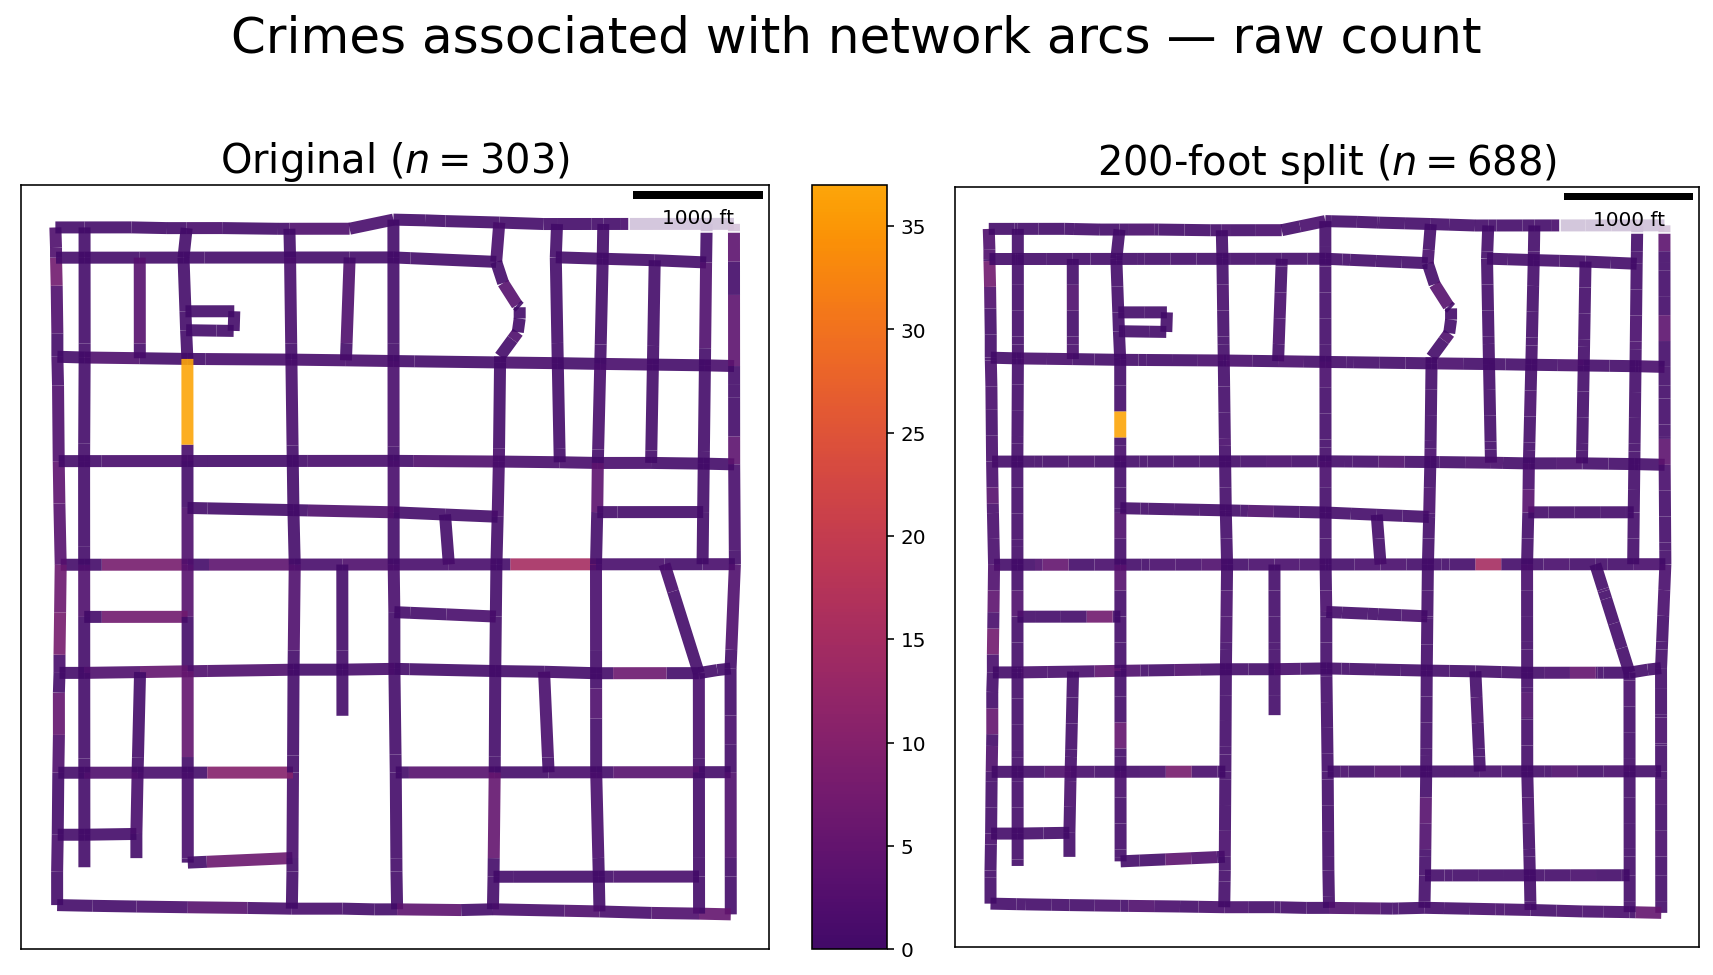

In [20]:
suptitle = "Crimes associated with network arcs — raw count"
subtitle1  = "Original ($n=%s$)" % arc_df.shape[0]
subtitle2 = "200-foot split ($n=%s$)" % arc200_df.shape[0]
title_args = (suptitle, subtitle1, subtitle2)
sidexside_plot(arc_df, arc200_df, "n_crimes", out_cmap, *title_args)

#### Empirical data — Transformed counts (`log10`)

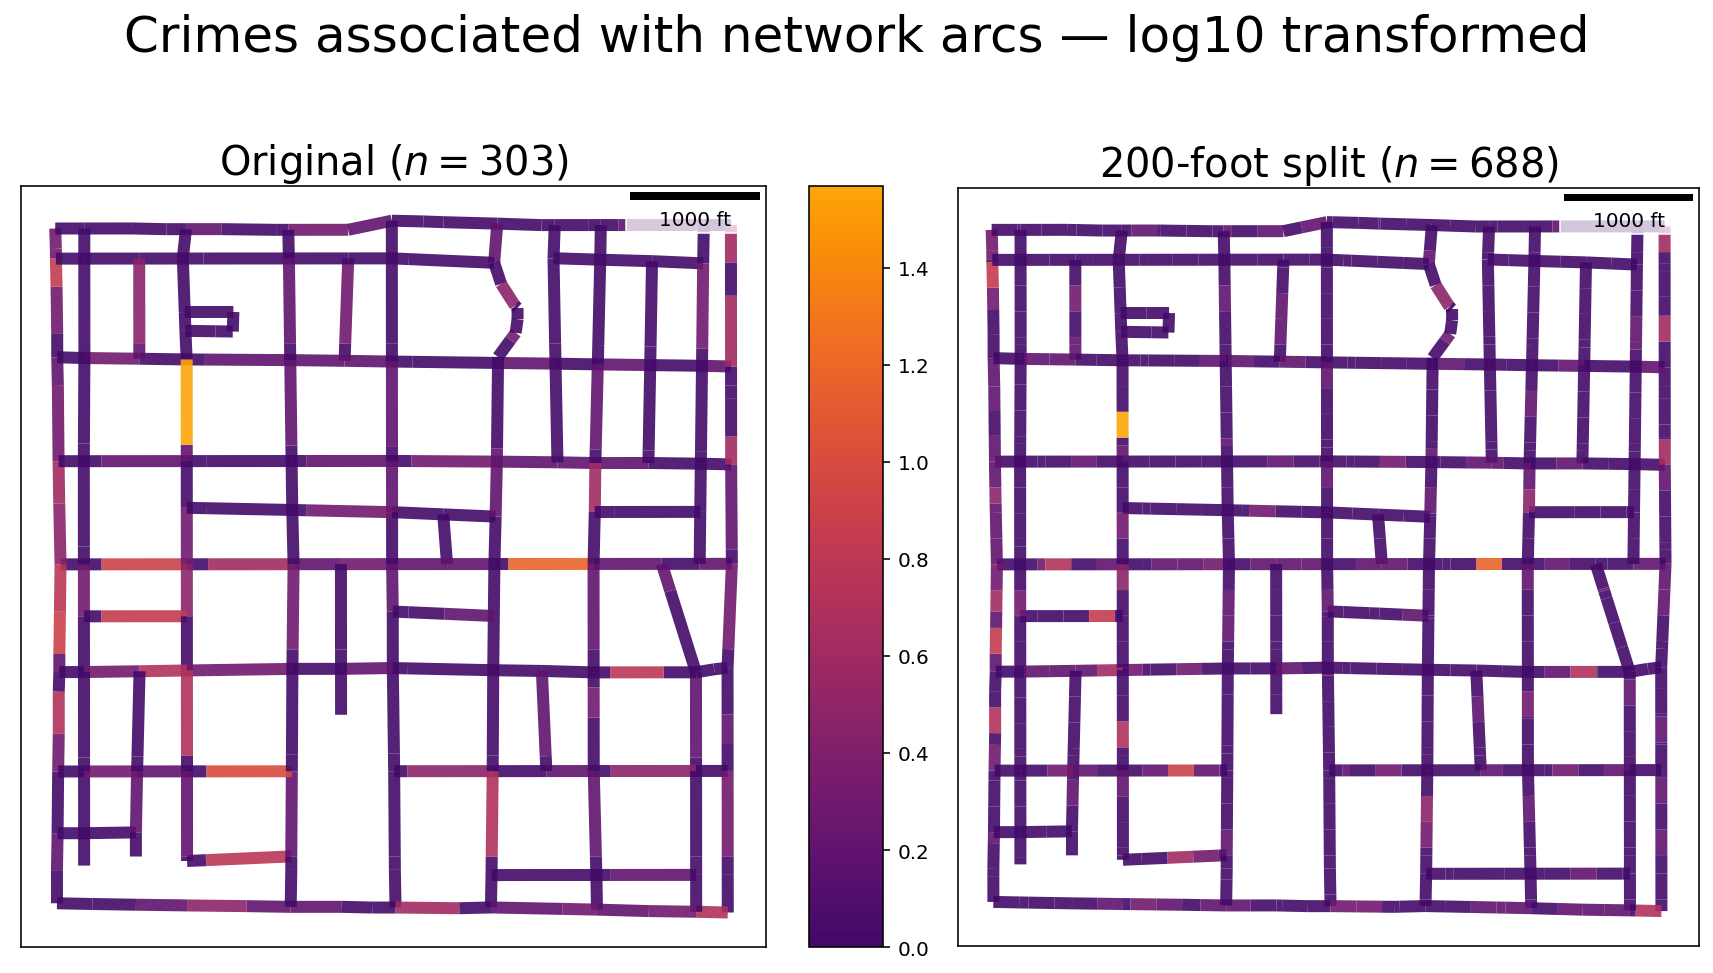

In [21]:
suptitle = "Crimes associated with network arcs — log10 transformed"
subtitle1  = "Original ($n=%s$)" % arc_df.shape[0]
subtitle2 = "200-foot split ($n=%s$)" % arc200_df.shape[0]
title_args = (suptitle, subtitle1, subtitle2)
sidexside_plot(arc_df, arc200_df, "n_crimes_log10", out_cmap, *title_args)

----------------------------------------------
####  Large synthetic clusters

In [22]:
ncrimes, cluster_crimes = 400, []; numpy.random.seed(0)
minx, miny, maxx, maxy = [725400, 877400, 727100, 879100]
for c in range(ncrimes):
    for pm in [1000, -2000]:
        x = numpy.random.uniform(minx+pm, maxx+pm)
        y = numpy.random.uniform(miny+pm, maxy+pm)
        cluster_crimes.append(libpysal.cg.Point((x,y)))

In [23]:
pp_name = "crimes"
ntw.snapobservations(cluster_crimes, pp_name, attribute=True)
pp_df = spaghetti.element_as_gdf(ntw, pp_name=pp_name)

In [24]:
ntw_counts, ntw_ctmean = fetch_cpl(ntw, pp_name)
n200 = ntw.split_arcs(200.0)
n200_counts, n200_ctmean = fetch_cpl(n200, pp_name)

In [25]:
vtx_df, arc_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
vtx200_df, arc200_df = spaghetti.element_as_gdf(n200, vertices=True, arcs=True)

In [26]:
arc_df = counts_col(ntw_counts, arc_df, "id", "n_crimes")
arc200_df = counts_col(n200_counts, arc200_df, "id", "n_crimes")

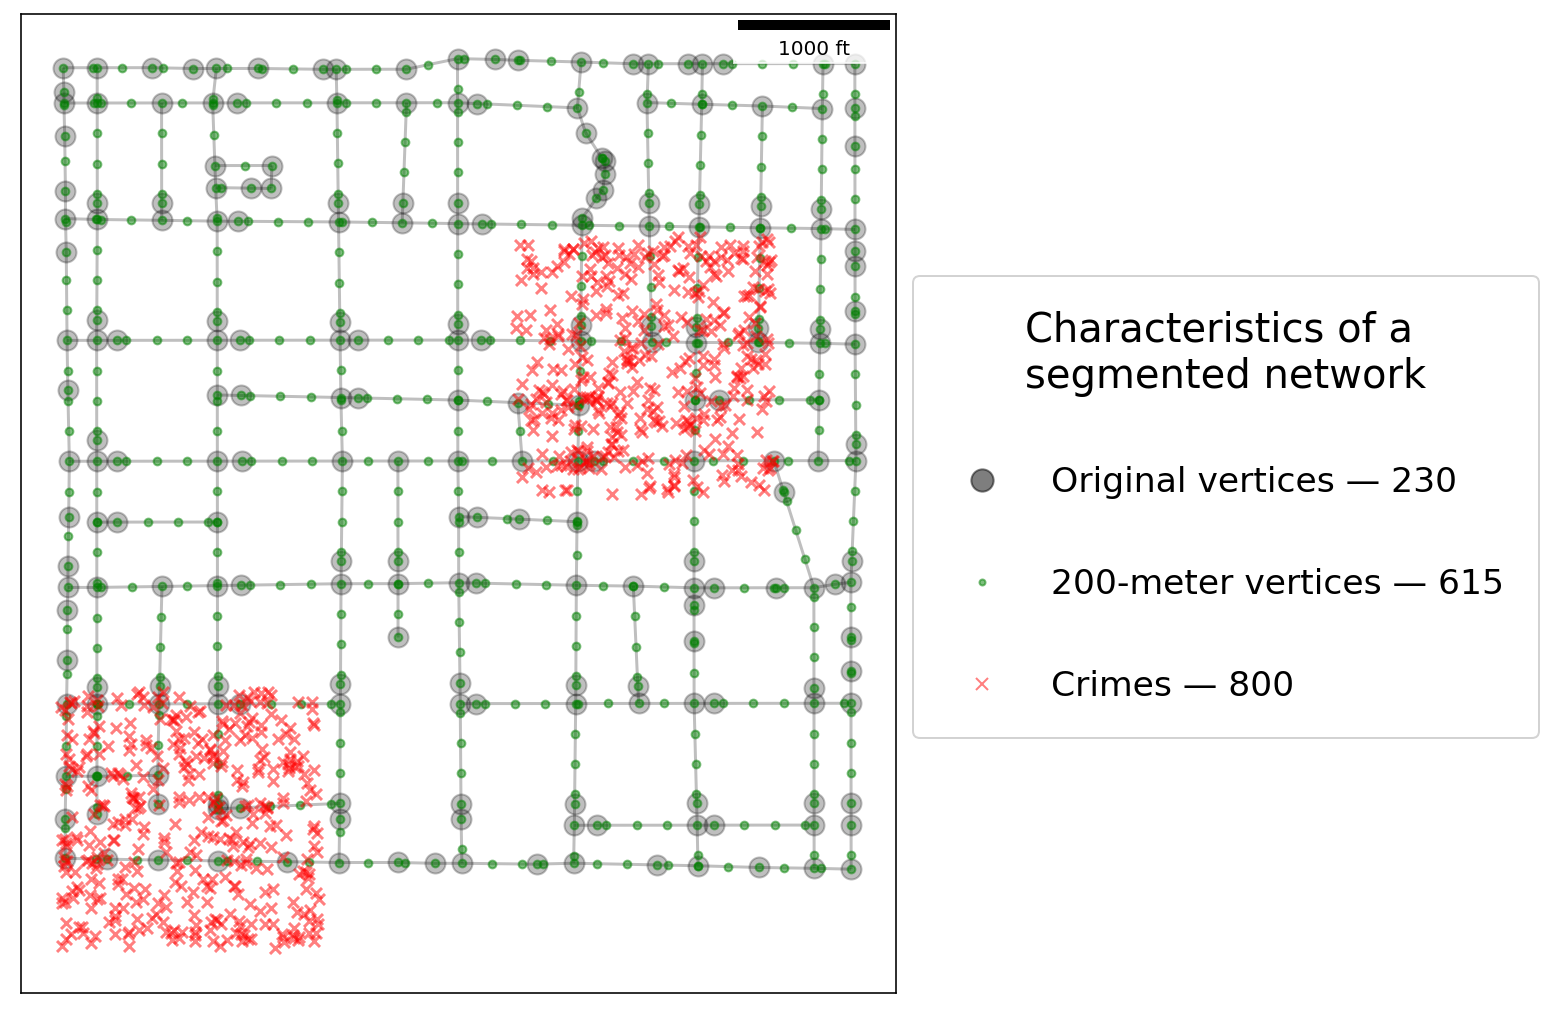

In [27]:
plotter()

#####  Large synthetic clusters — Raw counts

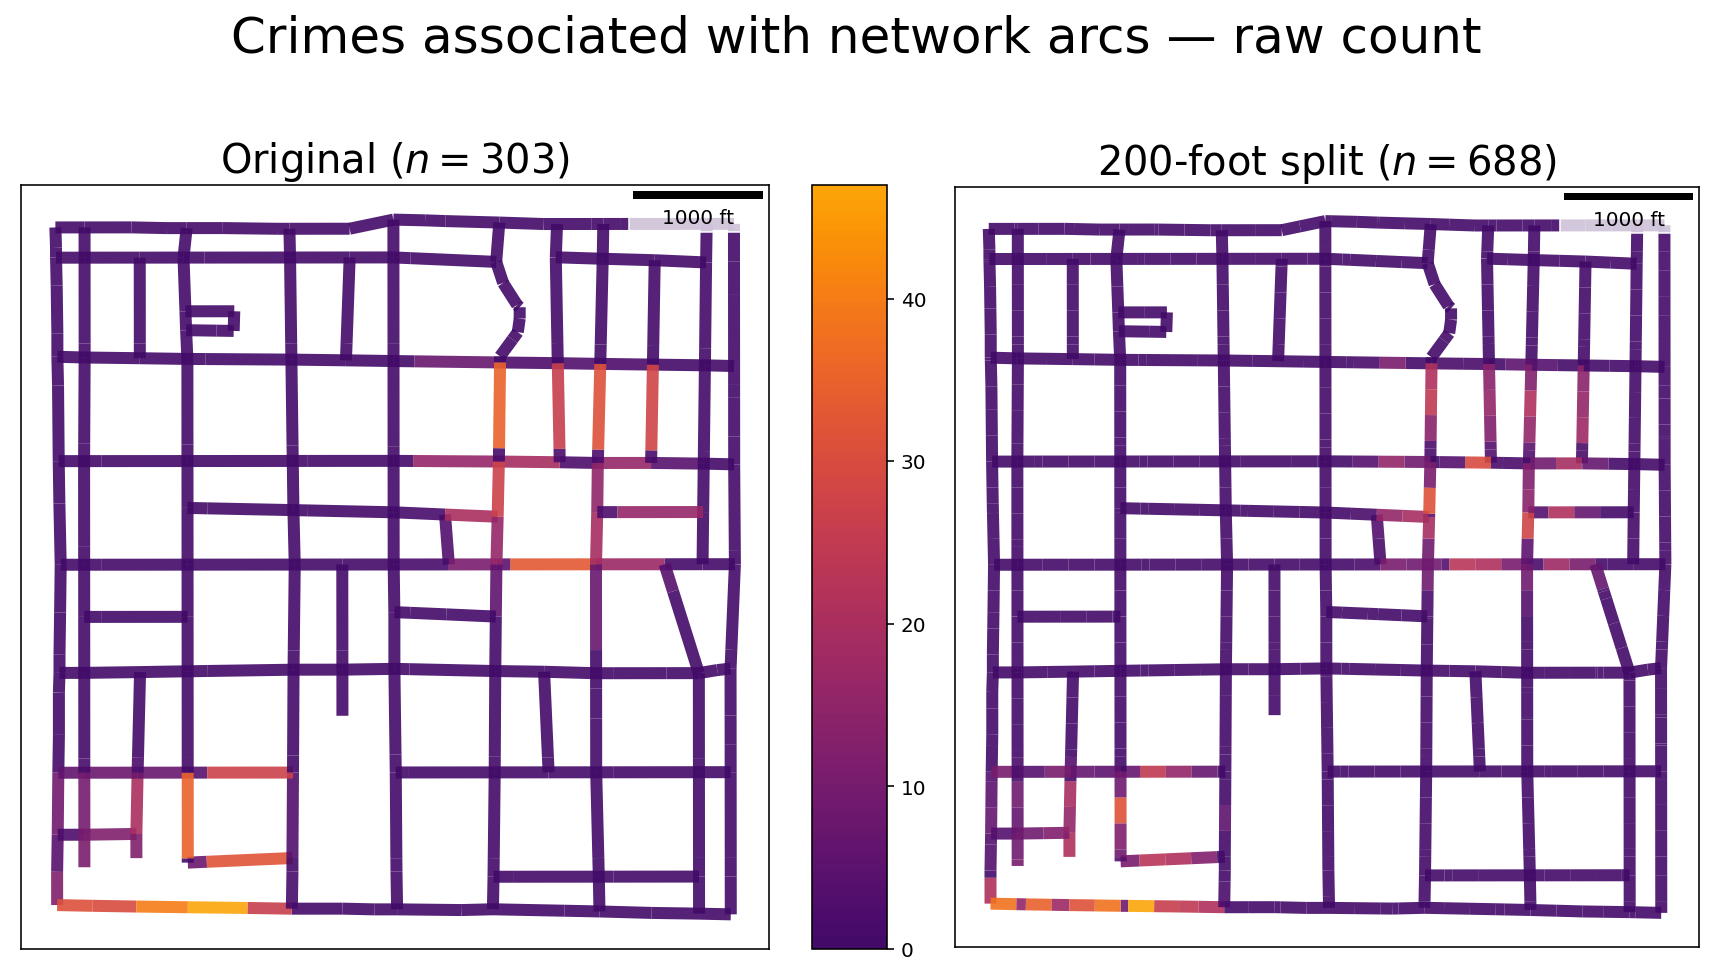

In [28]:
suptitle = "Crimes associated with network arcs — raw count"
subtitle1  = "Original ($n=%s$)" % arc_df.shape[0]
subtitle2 = "200-foot split ($n=%s$)" % arc200_df.shape[0]
title_args = (suptitle, subtitle1, subtitle2)
sidexside_plot(arc_df, arc200_df, "n_crimes", out_cmap, *title_args)

#####  Large synthetic clusters — Transformed counts (`log10`)

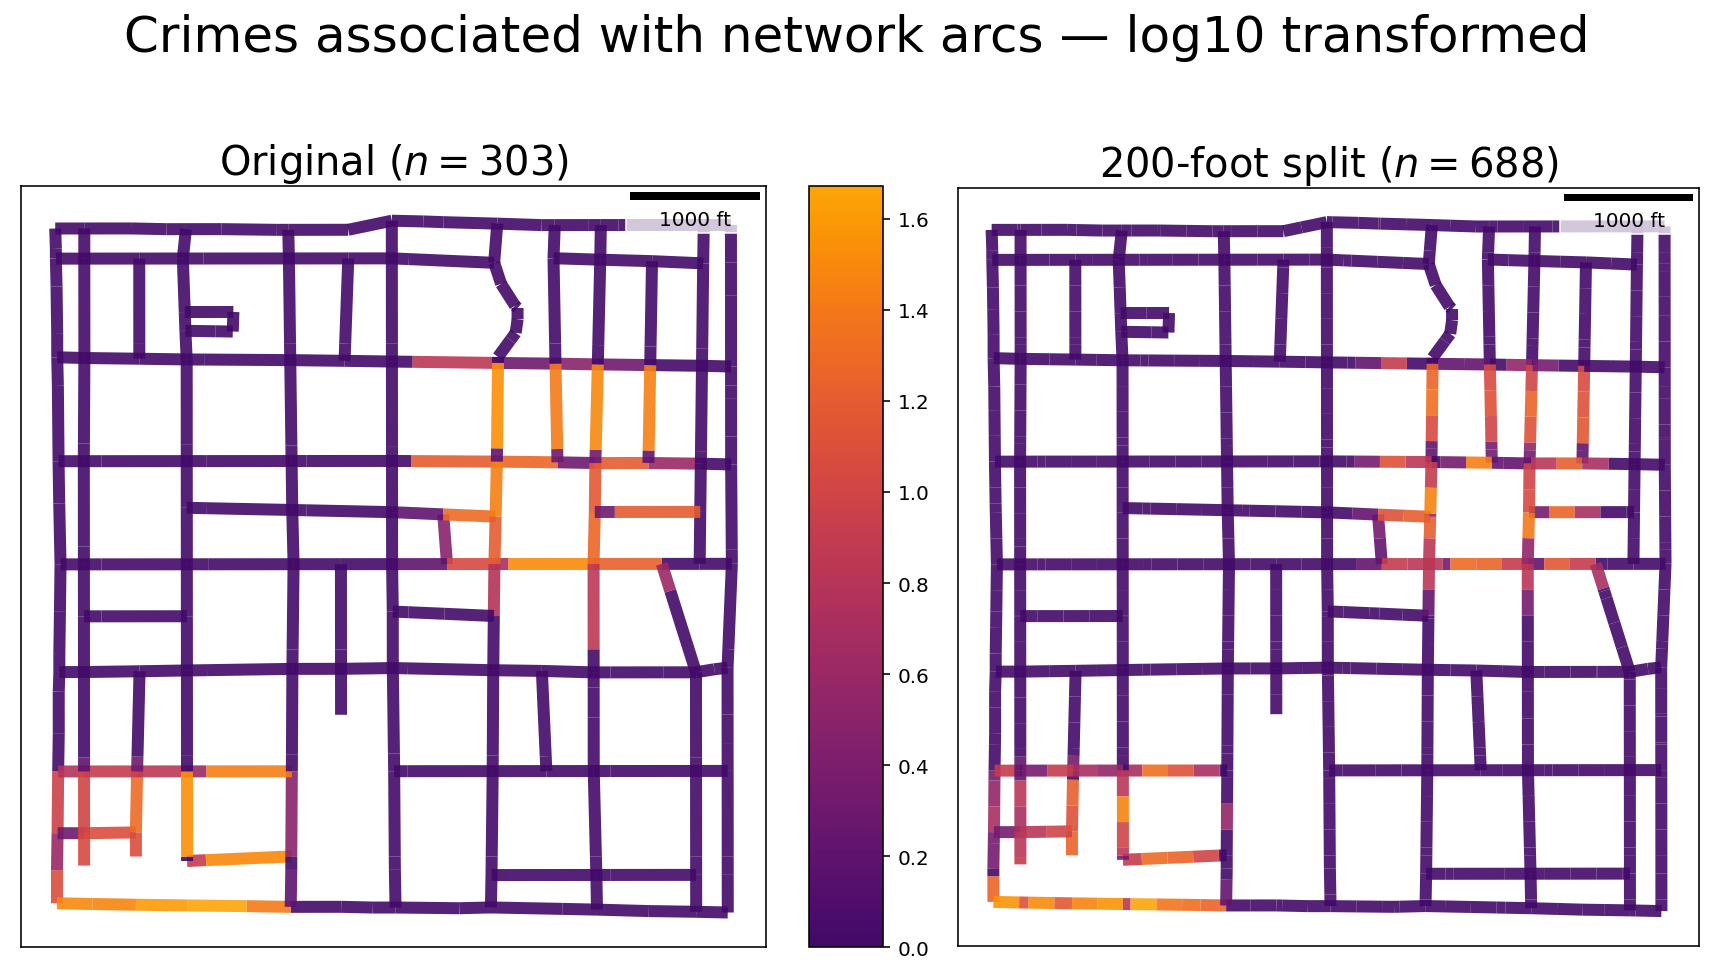

In [29]:
suptitle = "Crimes associated with network arcs — log10 transformed"
subtitle1  = "Original ($n=%s$)" % arc_df.shape[0]
subtitle2 = "200-foot split ($n=%s$)" % arc200_df.shape[0]
title_args = (suptitle, subtitle1, subtitle2)
sidexside_plot(arc_df, arc200_df, "n_crimes_log10", out_cmap, *title_args)

--------------------------